# HAM10000 MEfficientNet
In this notebook we will experiment with pre-trained efficienet models. We will be using Mish Activation with Ranger Optimization. 

In [1]:
from fastai.script import *
from fastai.vision import *
from torchvision.models import *
from mxresnet import *

from ranger import *
from annealing import *

from MEfficientNet.mefficientnet import EfficientNet as MEfficientNet

In [2]:
torch.cuda.set_device(0)

In [3]:
path = './data/ham10000'
path = Path(path)
path.ls()

[WindowsPath('data/ham10000/HAM10000_metadata.csv'),
 WindowsPath('data/ham10000/hmnist_28_28_L.csv'),
 WindowsPath('data/ham10000/hmnist_28_28_RGB.csv'),
 WindowsPath('data/ham10000/hmnist_8_8_L.csv'),
 WindowsPath('data/ham10000/hmnist_8_8_RGB.csv'),
 WindowsPath('data/ham10000/images'),
 WindowsPath('data/ham10000/labels.csv'),
 WindowsPath('data/ham10000/models')]

In [4]:
bs = 12

data = (ImageList.from_csv(path, 'labels.csv', folder='images', suffix='.jpg')
        # Splitting by 10%
        .split_by_rand_pct(.10)
        # Labeling with col1 = 'lesion'
        .label_from_df(cols=1)
        # Will only use size transformation
        .transform(size=224//2)
        # Turning into our databunch object:
        .databunch(bs=bs, num_workers=1).normalize(imagenet_stats))      

In [5]:
# efficientnets
effnet_b0 = 'efficientnet-b0'
effnet_b1 = 'efficientnet-b1'
effnet_b2 = 'efficientnet-b2'
effnet_b3 = 'efficientnet-b3'
effnet_b4 = 'efficientnet-b4'
effnet_b5 = 'efficientnet-b5'
effnet_b6 = 'efficientnet-b6'
effnet_b7 = 'efficientnet-b7'

In [6]:
#export
def get_mish_model(data, model_name, pre_trained=True):
    if pre_trained: 
        return MEfficientNet.from_pretrained(model_name, data.c)
    else:
        return MEfficientNet.from_name(model_name, override_params={'num_classes': data.c})

## Testing Model: EfficientNet; Pretrained

In [9]:
# hyper parameters
lr = 4e-3
alpha = 0.99
mom = 0.95
eps = 1e-6
epochs = 5
mixup = 0.3
sa = 1
sym = 0
ann_start = 0.72
wd = 1e-2

# b4 model: around the same parameters as mxresnet34
m = get_mish_model(data, effnet_b3, pre_trained=True)

# opt, loss
opt_func = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = LabelSmoothingCrossEntropy()

# learner
learn = (Learner(data,
                 m, 
                 wd=wd,
                 opt_func=opt_func,
                 metrics=[accuracy, top_k_accuracy],
                 bn_wd=False, true_wd=True,
                 loss_func=loss_func)
        )

# adding mixup
if mixup > 0.:
    learn.mixup(alpha=alpha);
# to mixed precision
learn.to_fp16();

Loaded pretrained weights for efficientnet-b3


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


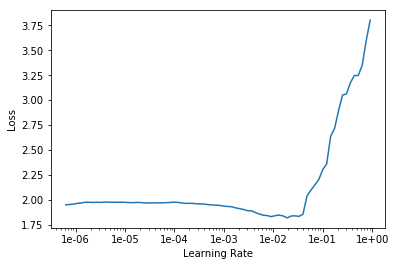

In [10]:
# finding optimal learning rate
learn.lr_find(wd=wd)
learn.recorder.plot()

In [11]:
lr = 1e-2
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.207631,1.748782,0.668332,0.942058,07:16
1,1.181949,1.201892,0.680320,0.935065,07:20
2,1.190396,1.375849,0.674326,0.958042,07:32
3,1.110794,1.030487,0.736264,0.990010,07:47
4,1.087692,0.961589,0.757243,0.992008,07:26


## Testing Model: Efficientnet Non-Pretrained

In [7]:
# hyper parameters
lr = 4e-3
alpha = 0.99
mom = 0.95
eps = 1e-6
epochs = 5
mixup = 0.3
sa = 1
sym = 0
ann_start = 0.72
wd = 1e-2

# b4 model: around the same parameters as mxresnet34
m = get_mish_model(data, effnet_b3, pre_trained=False)

# opt, loss
opt_func = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = LabelSmoothingCrossEntropy()

# learner
learn = (Learner(data,
                 m, 
                 wd=wd,
                 opt_func=opt_func,
                 metrics=[accuracy, top_k_accuracy],
                 bn_wd=False, true_wd=True,
                 loss_func=loss_func)
        )

# adding mixup
if mixup > 0.:
    learn.mixup(alpha=alpha);
# to mixed precision
learn.to_fp16();

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


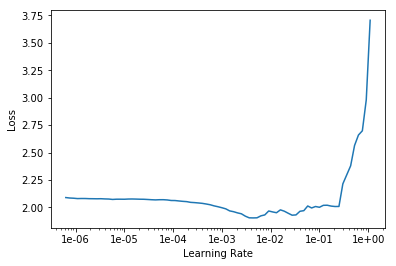

In [8]:
# finding optimal learning rate
learn.lr_find(wd=wd)
learn.recorder.plot()

In [9]:
lr = 1e-3
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.213176,1.155151,0.690310,0.963037,07:26
1,1.182982,1.119087,0.700300,0.980020,07:36
2,1.154574,1.087729,0.678322,0.986014,07:37
3,1.122843,1.117936,0.680320,0.976024,07:52
4,1.148751,1.008329,0.714286,0.993007,07:43
